# Lab Session - Probability Distributions and Basic ML Concepts
---

In this lab session, we are going to consider various probability distributions, conjugacy, Maximum Likelihood and overfitting, as covered in lecture 2 and 3.

__Note__: You can complete the lab entering code only in the  __# EXPECTED SPACE FOR STUDENT CODE__-blocks as well as the empty cells.

In [1]:
# Imports
# Can be installed through "pip install numpy scipy pandas matplotlib"
import time
from functools import partial
import numpy as np
from scipy.stats import norm, beta 
from scipy.linalg import det, inv
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from utils import plot_gaussian, show_images, show_marginals

from scipy.stats.contingency import margins
import scipy.integrate as integrate


# Exercise 1: Gaussian Distributions

We will start by considering the most prevalent distribution - the Gaussian. As stated in Lecture 2 (Section on Gaussians) the Gaussian has several appealing properties that makes it easy to work with. In the following tasks, we will highlight some of these.

**Note:** For the following tasks, the purpose is to understand the properties of Gaussian distributions. As such, any readly-made distributions (scipy.stats.norm etc.) are disallowed. Using NumPy or SciPy for Linear Algebra is permitted.

Below, you see an implementation of a Gaussian distribution. We will use this highlight and implement properties that are typical of the Gaussian distribution. Please read through, and note the dunder (double under, \_\__methodname_\__) methods that are implemented. These allow us to add and subtract one Gaussian with another.

In [2]:
class GaussianDistribution:
    
    def __init__(self, mean, cov):
        """
        A Gaussian Distribution in arbitrary number of dimensions

        Args:
            mean (np.ndarray): Mean of the distribution.
            cov (np.ndarray): Covariance of the distribution.
        """
        self.mean = np.array(mean).reshape(1, -1)
        self.cov = np.array(cov)
        self.dims = self.mean.shape[1]
        
    def __str__(self):
        """
        Generates a string representation of the object, used for plotting
        and printing

        Returns:
            str: String representation of the object
        """        
        if self.dims == 2:
            string = f'Gaussian, Dim: {self.dims}    Mean: {self.mean}    Covariance: {self.cov[0, :]}{self.cov[1, :]}'
            
        else:
            string = f'Gaussian, Dim: {self.dims}    Mean: {np.round(self.mean[0, 0], 6)}    Covariance: {self.cov}'
        return string.replace('][', '     ').replace('[', '  ').replace(']', '  ')
        
    
    def __add__(self, other):
        """
        Adds two GaussianDistributions (or GaussianDistribution + scalar)
        together, assuming zero cross-covariance.

        Args:
            other (GaussianDistribution): Another GaussianDistribution
            of the same dimensionality

        Returns:
            GaussianDistribution: The resulting distribution
        """
        if not isinstance(other, type(self)):
            other = np.array(other)
            mean = self.mean + other
            cov = self.cov
        
        else:
            mean = self.mean + other.mean
            cov = self.cov + other.cov
        
        return GaussianDistribution(mean, cov)
              
    def __sub__(self, other):
        """
        Subtracts two GaussianDistributions (or GaussianDistribution + scalar)
        together, assuming zero cross-covariance.

        Args:
            other (GaussianDistribution): Another GaussianDistribution
            of the same dimensionality

        Returns:
            GaussianDistribution: The resulting distribution
        """
        if not isinstance(other, type(self)):
            other = np.array(other)
            mean = self.mean - other
            cov = self.cov
            
        else:
            mean = self.mean - other.mean
            cov = self.cov + other.cov
        
        return GaussianDistribution(mean, cov)  
           
    # sampling is a bit intricate - thus, we cheat a little bit here
    def sample(self, n_samples=1):
        """
        Samples from the distribution.

        Args:
            n_samples (int, optional): The number of samples to generate.
            Defaults to 1.

        Returns:
            np.ndarray: A numpy array of the sampled points.
        """        
        return norm(self.mean, self.cov).rvs(n_samples)
            
    # probability density function - general form
    def pdf(self, points):
        '''
        Evaluates the probability density function of the distribution.

        Args:
            points (np.ndarray): the points we want the probability density of,
            can come in either a list, np.array([dims]) or np.array([samples, dims])
            format
        
        Returns: 
            np.ndarray: A numpy array of probability densities
        '''

        points = np.array(points)
        if len(points.shape) == 1:
            points = points.reshape(1, -1)
            
        offset = points - self.mean
        if self.dims == 1:
            norm_const = 1.0 / (np.power(2*np.pi, float(self.dims)/2) * np.sqrt(self.cov))
            exponent = np.exp(-0.5 * np.power(offset, 2) / self.cov)
            return norm_const * exponent
            
        else:
            norm_const = 1.0 / (np.power(2*np.pi, float(self.dims)/2) * np.sqrt(det(self.cov)))
            exponent = np.exp(-0.5 * offset.dot((inv(self.cov)).dot(offset.T)))
            return np.diag(exponent * norm_const)
    
    
    def get_conditional(self, dim, value):
        '''
        Computes the conditional distribution on the remaining dimensions given
        the conditioned value in dimension dim.

        Args:
            dim: int - the dimension (assume only one) which we condition on
            value: float - the value of the conditioned dimension
            
        Returns: 
            GaussianDistribution: a new distribution of dimension dim - 1
        '''
        y = value
            
        # EXPECTED SPACE FOR STUDENT CODE - START
        # some hints to help
        non_cond_dims = np.arange(self.dims) != dim
        cond_dims = np.arange(self.dims) == dim
        
        """
        Refer to slide 25 for variable names (y and x are actually multivariate)
        """
        
        cov_xy = self.cov[non_cond_dims, cond_dims][np.newaxis, :]
        cov_yx = self.cov[cond_dims, non_cond_dims][np.newaxis, :]

        cov_xx = self.cov[non_cond_dims, non_cond_dims][np.newaxis, :]
        cov_yy = self.cov[cond_dims, cond_dims][np.newaxis, :]

        cov_yy_inv = inv(cov_yy)

        mu_x = self.mean[0][non_cond_dims]
        mu_y = self.mean[0][cond_dims]
        
        mu_cond = mu_x + np.dot( cov_xy, cov_yy_inv + (y - mu_y) )
        cov_cond = cov_xx - np.dot( cov_xy, np.dot( cov_yy_inv, cov_yx ) )

        # EXPECTED SPACE FOR STUDENT CODE - END
        
        return GaussianDistribution(mu_cond, cov_cond)

    def marginalize(self, dim):
        '''
        Computes the marginal distribution on the remaining dimensions when having
        marginalized out dimension dim.
        
        Args:
            dim: int - the dimension (assume only one) which we marginalize
            
        Returns: 
            GaussianDistribution: a new distribution of dimension dim - 1
        '''
            
        # EXPECTED SPACE FOR STUDENT CODE - START
        (marginal_mean, marginal_cov) = self.marginalize_helper(dim)
        # EXPECTED SPACE FOR STUDENT CODE - END
        
        return GaussianDistribution(marginal_mean, marginal_cov)

    def marginalize_helper(self, dim):
        marginal_mean = np.delete(self.mean, dim, 1)
        
        marginal_cov = np.delete(self.cov, dim, 0)
        marginal_cov = np.delete(marginal_cov, dim, 1)
        return (marginal_mean, marginal_cov)


### Exercise 1.1
We first want to demonstrate how a Gaussian looks and how it is expected to behave - particularly its linear properties. __Throughout this task, we assume that the random variables we work with are independent of one another__ (e.g. __A__ is independent of __B__). Create four Gaussians:

__A__: $\mu = 1, \sigma^2 = 2$

__B__: $\mu = -2, \sigma^2 = 0.1$

__C__: $\mu = \begin{bmatrix}
1 & 0
\end{bmatrix}, \quad\Sigma^2 = \begin{bmatrix}
1 & 0.9\\
0.9 & 2
\end{bmatrix}$

__D__: $\mu = \begin{bmatrix}
-1 & 2
\end{bmatrix}, \quad\Sigma^2 = \begin{bmatrix}
1 & -0.7\\
-0.7 & 1
\end{bmatrix}$

Visualize, through the provided plotting function below, _plot_gaussian_:

a. __A__

b. __B__

c. __A__ + __B__

d. __C__

e. __D__

f. __C__ - __D__

__Questions__:

1. What is meant by "The Gaussian distribution is fully characterized by its mean and covariance"?
2. If two Gaussians are added, can the (co-)variance ever decrease?

__Answers__:
1. You can find the entire distribution from just those two values
2. Yes, if the covariance is negative on one of them.

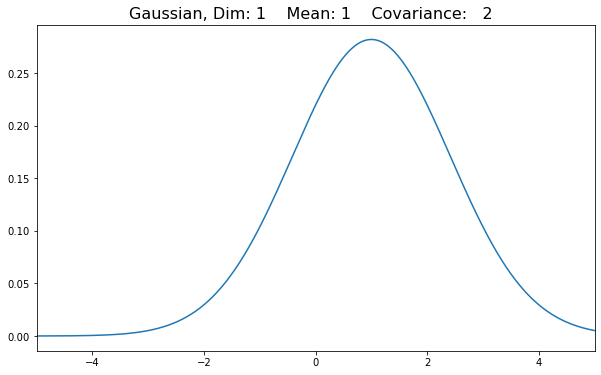

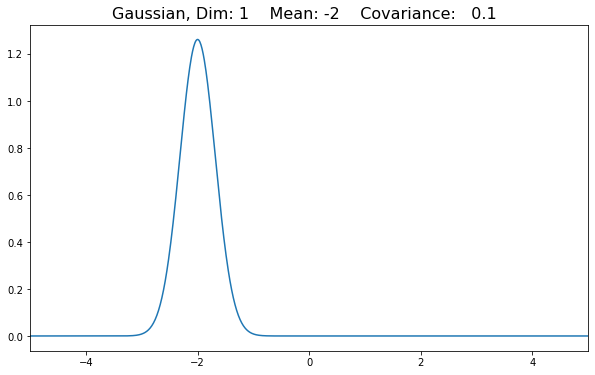

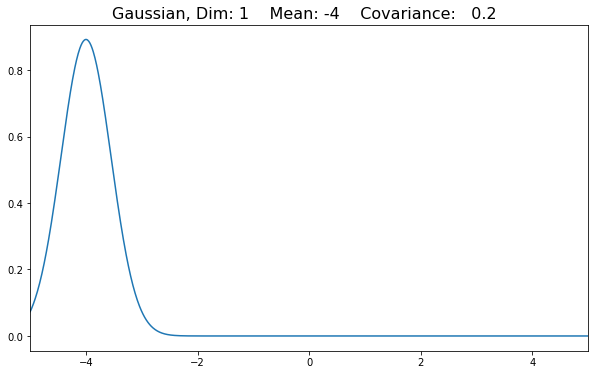

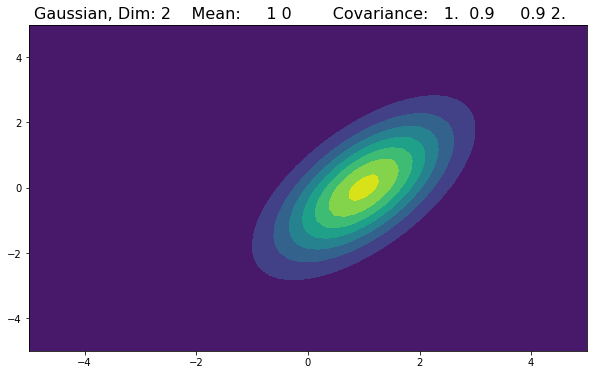

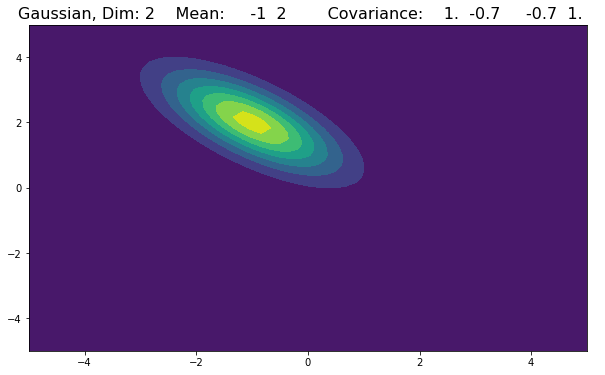

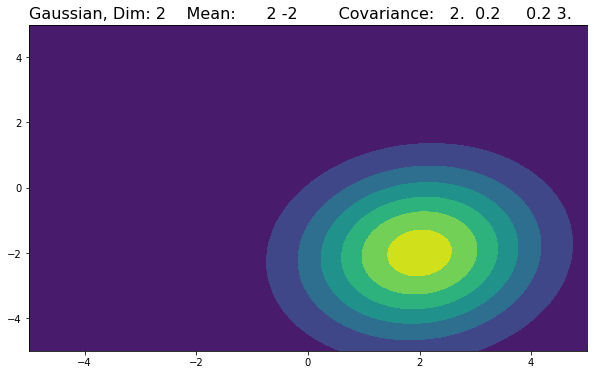

In [3]:
# EXPECTED SPACE FOR STUDENT CODE - START
gaussian_A = GaussianDistribution(mean=np.array([1]), cov=np.array([2]))
# plot_gaussian(gaussian_A)

gaussian_B = GaussianDistribution(mean=np.array([-2]), cov=np.array([0.1]))
# plot_gaussian(gaussian_B)

gaussian_C = GaussianDistribution(mean=np.array([1, 0]), cov=np.array([[1, 0.9], [0.9, 2]]))
# plot_gaussian(gaussian_C)

gaussian_D = GaussianDistribution(mean=np.array([-1, 2]), cov=np.array([[1, -0.7], [-0.7, 1]]))
# plot_gaussian(gaussian_D)


plot_gaussian(gaussian_A)
plot_gaussian(gaussian_B)
plot_gaussian(gaussian_B.__add__(gaussian_B))
plot_gaussian(gaussian_C)
plot_gaussian(gaussian_D)
plot_gaussian(gaussian_C.__sub__(gaussian_D))

# EXPECTED SPACE FOR STUDENT CODE - END

### Exercise 1.2
__Task__: Implement the _marginalize_ function of the class GaussianDistribution. Test, for __C__, that your resulting Gaussian looks like the one in the plot. Plot the resulting distribution for __C__ when marginalizing on $y$, and on __D__ when marginalizing on $x$.

__Question__: What does one effectively do when marginalizing a variable of a distribution?

__Answer__:
We remove the variable from consideration by summing out, or integrating, all possible values of it.

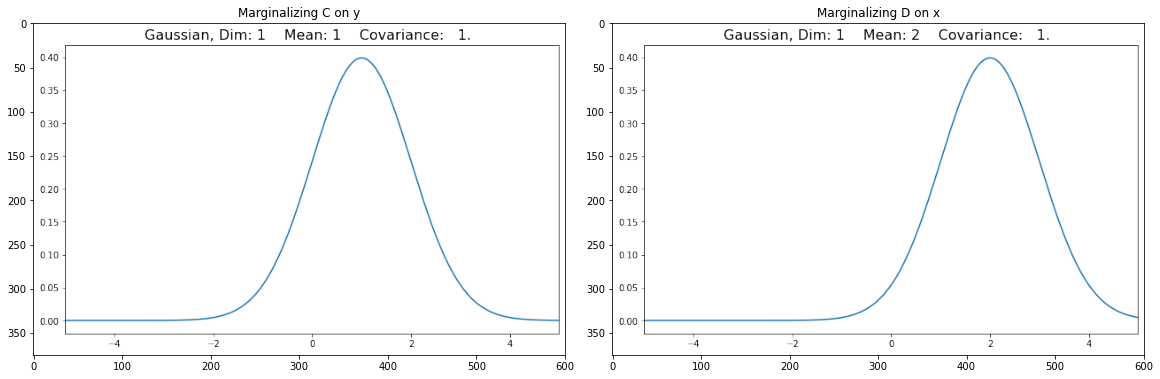

In [4]:
show_marginals()

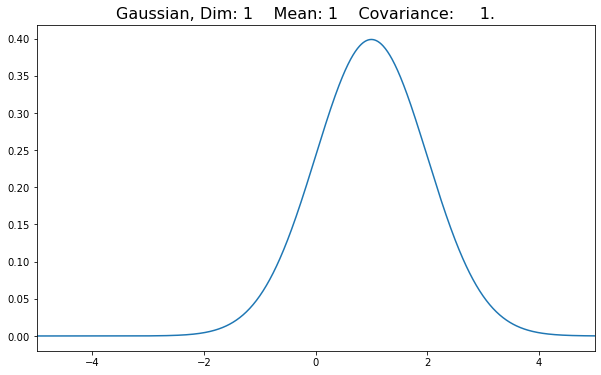

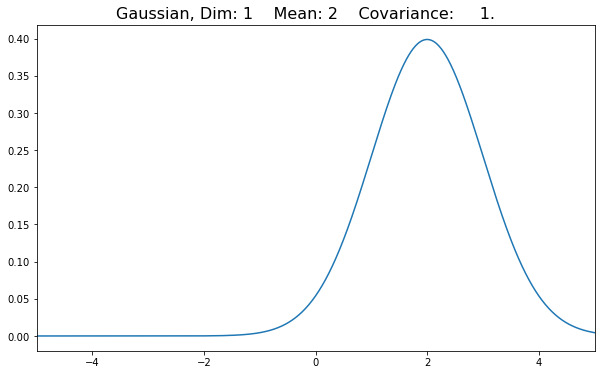

In [5]:
# Some code to test if you've marginalized distribution C correctly
marg_C = gaussian_C.marginalize(dim=1)
plot_gaussian(marg_C)

marg_D = gaussian_D.marginalize(dim=0)
plot_gaussian(marg_D)

### Exercise 1.3
__Task__: Implement the _get_conditional_ function of the class GaussianDistribution, as specified in Lecture 2 on Gaussians. Test, for the Gaussians __C__ and __D__ from 1.1, that your resulting conditional looks like the ones in the plots, when conditioning on $x=2$ and $y=4$, respectively. 

__Hint 1__: Use the numpy arrays to retrieve the right dimensions when performing the computation (_cond_dims_ are the dimensions we condition on - $y$ in the lecture notes, _non_cond_dims_ are the non-conditioned dimensions - $x$ in the lectures). Example:

$\Sigma_{yx} = $ self.cov[cond_dims, non_cond_dims][:, np.newaxis]

__Hint 2__: Use either np.matmul, np.dot or the @ operator to perform matrix matrix multiplications.

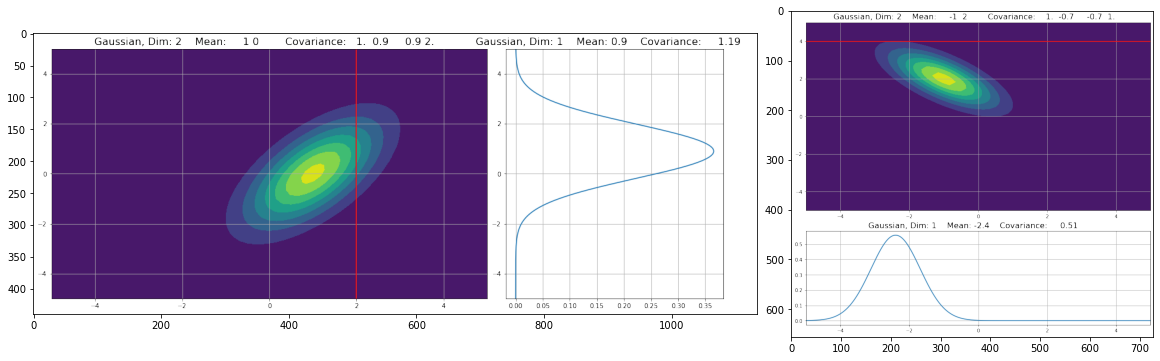

In [6]:
show_images()

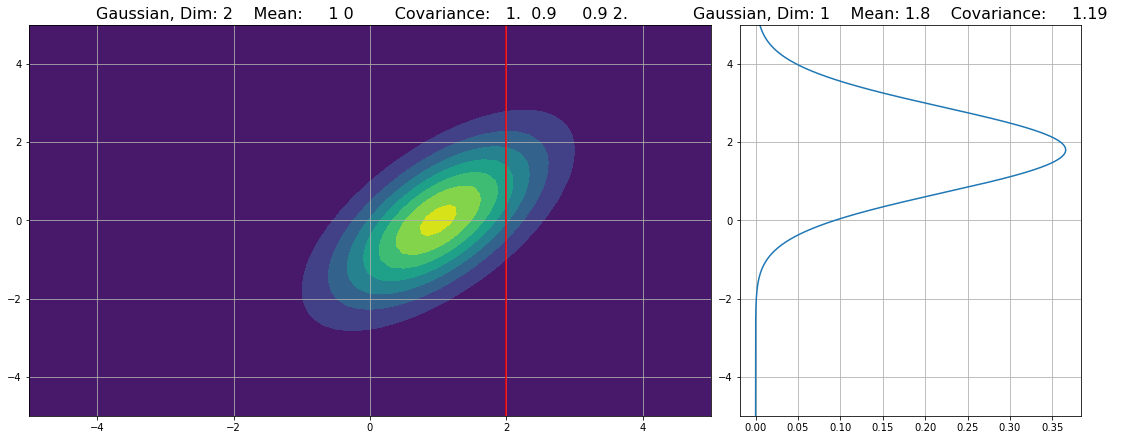

In [7]:
# Test that this produces the same plot (including the colors, which indicates the computed pdf)
gaussian_C = GaussianDistribution(mean=np.array([1, 0]), cov=np.array([[1, 0.9], [0.9, 2]]))

# Use these lines to compute the conditionals
conditional_C = gaussian_C.get_conditional(dim=0, value=2)

# Use these lines to generate the plots - plots both the initial distribution and the conditional along the right axis
plot_gaussian(gaussian_C, conditional_dist=conditional_C, condition_axis=0, condition_value=2)

# Exercise 2: Conjugate Priors

Here, we will consider the example of flipping a coin. The coin may be biased, and has a probability $\mu$ of heads. The probability of m number of heads in $N$ flips of a coin is a typical case of a *Binomial* distribution, with parameters $\mu, N$.

We would like to infer the probability $\mu$ of getting heads. We know the following in advance:
- A normal coin should have $\mu=0.5$
- The coin is weird in some way, so we cannot be sure that $\mu=0.5$ 

To model this problem using Bayesian Inference, we want two things:
- A prior probability distribution over $\mu$ (our belief of $\mu$ before seeing it)
- A likelihood function - a probability distribution over our number of observed heads (which are *$Bin(m|N, \mu$)*)

In this case, the typical choice of prior probability distribution would be a *Beta* prior (with parameters $\alpha$, $\beta$), like the one below:

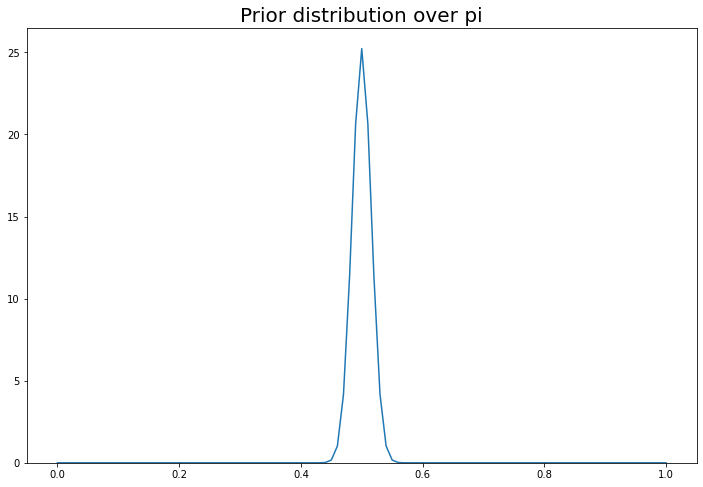

In [8]:
prior_alpha, prior_beta = 500, 500
pi_heads_prior = beta(prior_alpha, prior_beta)

x = np.linspace(0, 1, 101)
y = pi_heads_prior.pdf(x)
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(x, y)
ax.set_ylim(0)
ax.set_title('Prior distribution over pi', fontsize=20)
plt.show()

**Note**
A draw from the Beta distribution is always a number between 0 and 1, and represents our belief of the probability that we will get heads. In the example above, it says that you still think that the coin has $\mu=0.5$ of heads (as that's where the probability mass is the largest).


## Exercise 2.1

**Question**:
Toy around with the parameters of the beta distribution above. Approximately which parameters would indicate that

a. You you think that $\mu = 0.8$? (name one combination of alpha and beta)

b. You you think that $\mu = 0.2$? (name one combination of alpha and beta)

c. You are almost certain that $\mu = 0.5$?

d. You genuinely have no idea?

**Answer**:

a. a = 8, b = 2

b. a = 2, b = 8

c. a = 500, b = 500

d. a = 1, b = 1

## Exercise 2.2

For the choices of distributions above (*Beta* prior, *Binomial* likelihood), the *Beta* distributions is a **conjugate prior**. This means that the posterior distribution will be of the same form as the prior. As such, when we observe our coinflips, we will update the *Beta* distribution we started with to reflect what we have learned from our observations.

**Task**: For the two coin flip datasets, compute the posterior over $\mu$ using the prior in 2.1 and the updating described in Lecture 2 on Beta-Binomial conjugacy. This method of updating the posterior distribution in closed form is unique for conjugate priors. 

In [9]:
# read the data and change the coin index
coin_index = 1
coin_flips = pd.read_csv(f'data/coin_{coin_index}.csv')
coin_flips.head(10)

,head
0,0
1,1
2,1
3,1
4,1
5,0
6,1
7,1
8,1
9,1


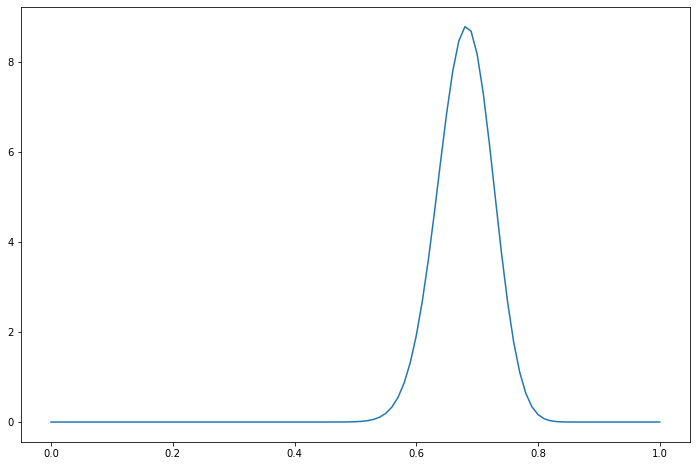

Final parameters of the distribution are
Alpha: 72 Beta:34


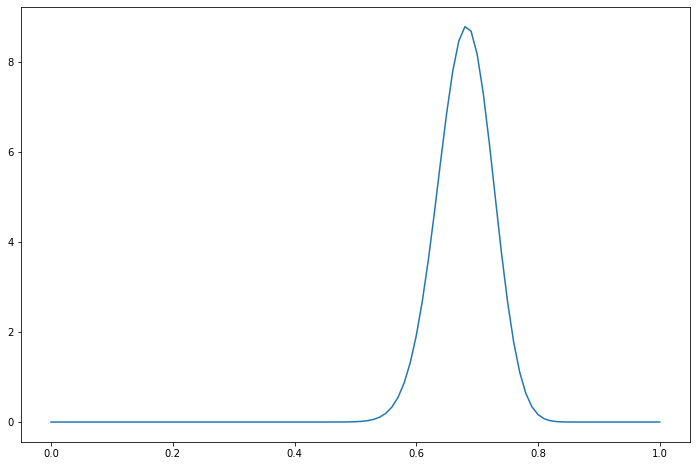

In [10]:
import time
import pylab as pl
from IPython import display

n_iterations = 100
prior_alpha, prior_beta = 3, 3
x = np.linspace(0, 1, 101)
plt.figure(figsize=(12, 8))

# plot prior before starting
y = beta(prior_alpha, prior_beta).pdf(x)
pl.plot(x, y)
display.clear_output(wait=True)
display.display(pl.gcf())

posterior_alpha, posterior_beta = prior_alpha, prior_beta

coin_flips_np = coin_flips.to_numpy()
for i in range(n_iterations):
    flip = coin_flips_np[i]
    
    # EXPECTED SPACE FOR STUDENT CODE - START

    if(flip == 1):
        posterior_alpha += 1
    else: 
        posterior_beta += 1
    
    posterior = beta(posterior_alpha, posterior_beta)
    
    # EXPECTED SPACE FOR STUDENT CODE - END
    
    # clear the plot at regular intervals - comment out if no clearing
    if i % 20 == 19:
        pl.clf()
        
    # get the values of the posterior
    y = posterior.pdf(x)
    pl.plot(x, y)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    
print('Final parameters of the distribution are\nAlpha: {} Beta:{}'.format(posterior_alpha, posterior_beta))

**Question**:
What posterior parameters $\alpha$, $\beta$ did you recieve for:

a. Coin index 1 using 10 flips?

b. Coin index 1 using 100 flips?

c. Coin index 2 using 10 flips?

d. Does the choice of prior matter for the the posterior distribution? When does it, and when does it not? Try for different priors and numbers of iterations.

**Answer**:

a. a = 11, b = 5

b. a = 72, b = 34

c. a = 4, b = 12

d. They would matter a lot if they were large in relation to our number of iterations.

# Exercise 3 - MLE, Overfitting and Cross-validation
Here, we are going to look at a synthetic regression problem, and how under- and overfitting can occur through better or worse model parameterizations. We will also look at the most common mean of evaluating model performance, namely cross-validation. We'll consider learning the function below through polynomial regression on a number of given data points:

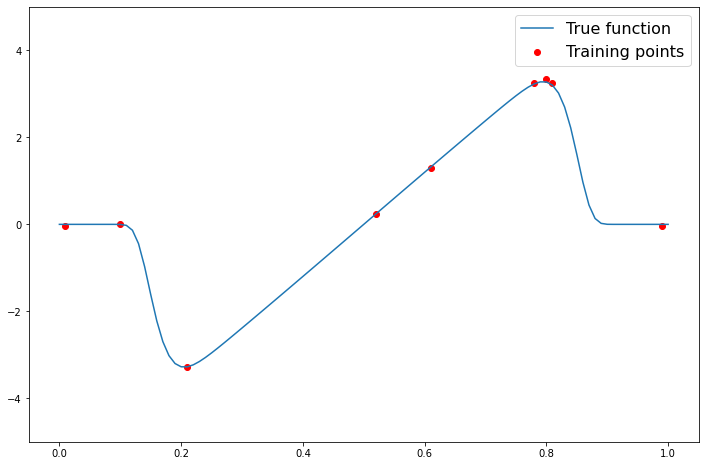

In [11]:
def true_function(X):
    return 12 * np.exp(-1e6 * np.power(1.2 * (X - 0.5), 16)) * np.sin((X - 0.5))

def noisy_function(X):
    return true_function(X) + np.random.randn(X.size) * 0.04

eval_points = np.array([0.01, 0.1, 0.21, 0.52, 0.61, 0.78, 0.80, 0.81, 0.99])
X_plot = np.linspace(0, 1, 101)

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(X_plot, true_function(X_plot), label='True function')
ax.scatter(eval_points, noisy_function(eval_points), c='r', label='Training points')
ax.legend(fontsize=16)
ax.set_ylim(-5, 5)
plt.show()

### Exercise 3.1
Look at the class _PolynomialRegression_ (a type of Generalized Linear Model) and pay attention to its attributes and _predict_ method. This class is intended to fit a polynomial of a given degree to the data points, by calling some method to fit the data points.

__Task__: Implement the closed-form Maximum Likelihood parameter estimation in the _fit_MLE_ method. The closed-form expression for the optimal parameters can be found in Lecture 3, on the section on Maximum Likelihood. Ensure it works by fitting a polynomial of degree 10 to the data points - it should fit most data points reasonably well.

__Hint__: Keep in mind that a polynomial of degree 2 has 3 coefficients.

In [26]:
class PolynomialRegression:
    
    def __init__(self, degree):
        """
        A Polynomial Regression model of a given degree,

        Args:
            degree (int): The degree of the polynomial regression.
        """        
        self.degree = degree
        self.weights = None
        
    def fit_MLE(self, X, y):
        """
        Fits the weights of the model according to the Maximum Likelihood.

        Args:
            X ([type]): The explanatory variables of the data.
            y ([type]): The dependent variables of the data.
        """ 
        # EXPECTED SPACE FOR STUDENT CODE - START

        # here, you fit the weights closed-form according to MLE
        
        phi = [[np.power(X[i],j) for j in range(self.degree+1)] for i in range(len(X))]
        self.weights = inv(np.transpose(phi).dot(phi)).dot(np.transpose(phi)).dot(y)

        # EXPECTED SPACE FOR STUDENT CODE - END
    
    def predict(self, X):
        """
        Predicts the output value(s) of a fitted model on the data point(s) X,

        Args:
            X ([type]): The explanatory variables of the data point(s) that is to 
            be predicted..

        Raises:
            ValueError: If no model is fitted (self.weights are None), no prediction
            can be made and an error is raised.

        Returns:
            np.ndarray: The predicted output value of the data point(s) X.
        """        

        if self.weights is None:
            raise ValueError('Need to fit the model before predicting!')

        theta = np.power(X[:, np.newaxis], np.arange(self.degree+1))
        preds = theta.dot(self.weights)
        return preds
            
    def print_weights(self):
        """
        Prints the weights of the model in a structured format.
        """        
        for i in range(self.degree):
            print('Coeff. theta^{}:   {:.2f}'.format(i, self.weights[i]))

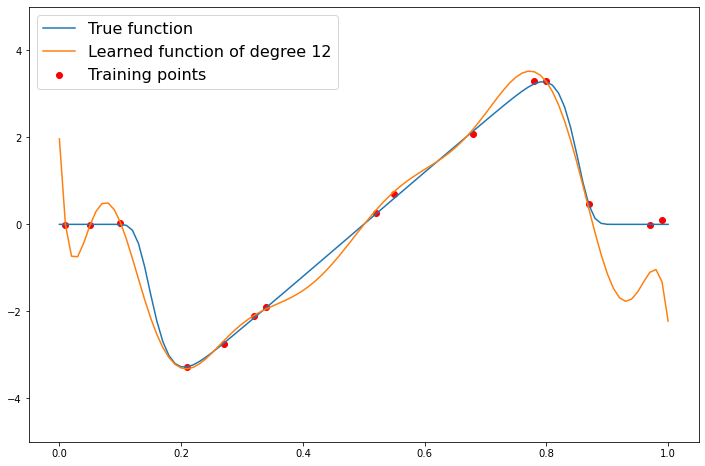

In [32]:
polynomial_degree = 12


pr = PolynomialRegression(polynomial_degree)

X_eval = np.array([0.01, 0.05, 0.1, 0.21, 0.27, 0.32, 0.34, 0.52, 0.55, 0.68, 0.78, 0.80, 0.87, 0.97, 0.99])
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
pr.fit_MLE(X_eval, y_eval)

# Plotting
X_plot = np.linspace(-0.0, 1.0, 101)
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(X_plot, true_function(X_plot), label='True function')

ax.scatter(X_eval, y_eval, c='r', label='Training points')
ax.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax.set_ylim(-5, 5)
ax.legend(fontsize=16)
plt.show()

### Exercise 3.2
We will now discover what happens if we under- and overfit parameters, as well as how additional data helps counteract overfitting. 

__Task__: Toy around with the fit of the generalized linear model below to find degrees where it under- and overfits. Try polynomials of different orders by changing the _polynomial_degree_ parameter. When you overfit, try change the _added_samples_ parameter.


__Questions__:

1. Judging by eye, which degree seems to consistently give the best fit?
2. How can one tell, only by looking at the parameter values of the model, if overfitting has occured?

__Answer__:

1. 
2. 

In [88]:
# Test out these parameters to answer the questions!
polynomial_degree = 20
added_samples = 30


pr = PolynomialRegression(polynomial_degree)
X_added = np.random.uniform(size=added_samples)
# calling noisy_function will sample new noise for each point!
y_eval = noisy_function(X_eval)
y_added = noisy_function(X_added)

all_X = np.append(X_eval, X_added, axis=0)
all_y = np.append(y_eval, y_added, axis=0)

pr.fit_MLE(all_X, all_y)
pr.print_weights()

Coeff. theta^0:   1.05
Coeff. theta^1:   -145.42
Coeff. theta^2:   4708.95
Coeff. theta^3:   -61832.12
Coeff. theta^4:   399170.58
Coeff. theta^5:   -1422352.67
Coeff. theta^6:   2839453.34
Coeff. theta^7:   -2729578.42
Coeff. theta^8:   -31853.28
Coeff. theta^9:   2270423.84
Coeff. theta^10:   -947395.46
Coeff. theta^11:   -452326.91
Coeff. theta^12:   -1322888.55
Coeff. theta^13:   2157215.13
Coeff. theta^14:   180103.98
Coeff. theta^15:   -914510.85
Coeff. theta^16:   -266342.95
Coeff. theta^17:   -1780508.35
Coeff. theta^18:   4953006.40
Coeff. theta^19:   -3922418.36


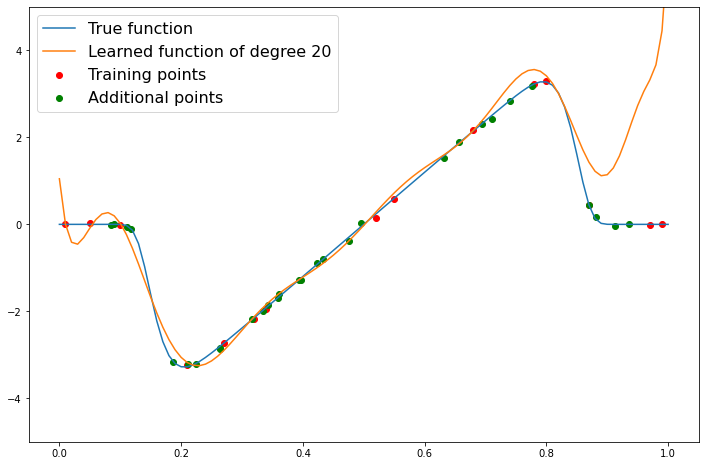

In [89]:
X_plot = np.linspace(0, 1, 101)
fig, ax = plt.subplots(1, figsize=(12, 8))


ax.plot(X_plot, true_function(X_plot), label='True function')

ax.scatter(X_eval, y_eval, c='r', label='Training points')
if added_samples > 0:
    ax.scatter(X_added, y_added, c='g', label='Additional points')
ax.plot(X_plot, pr.predict(X_plot), label=f'Learned function of degree {polynomial_degree}')
ax.set_ylim(-5, 5)
ax.legend(fontsize=16)
plt.show()

### Exercise 3.3
To evaluate the models produced, one commonly uses cross-validation. 

__Task__: Implement K-fold cross validation and find your best model with RMSE error as your metric. Plot the best model. Use only the initial data, without additional samples. Implement yourself or use an existing tool, e.g.  <a href="http://scikit-learn.org/stable/modules/cross_validation.html" title="Scikit-Learn Cross Validation">Scikit-Learn</a>.

__Tip__: Ensure nearby points don't go in the same batch, so that every model has data from the entire space.

__Question__:
What performance (RMSE, average on the test sets) did your top-performing model yield for K = 5?

__Challenge__: Find a model with a cross-validation RMSE below __0.5__!

__Answer__:
Degree 4 was awesome!

In [91]:
# EXPECTED SPACE FOR STUDENT CODE - START
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

print('degree, RMSE')

for i in range(1,15):
        # Test out these parameters to answer the questions!
        polynomial_degree = i
        added_samples = 30


        pr = PolynomialRegression(polynomial_degree)
        X_added = np.random.uniform(size=added_samples)
        # calling noisy_function will sample new noise for each point!
        y_eval = noisy_function(X_eval)
        y_added = noisy_function(X_added)

        all_X = np.append(X_eval, X_added, axis=0)
        all_y = np.append(y_eval, y_added, axis=0)

        pr.fit_MLE(all_X, all_y)

        n_splits = 5
        kf = KFold(n_splits=n_splits)

        sum_rmse = 0
        for train, test in kf.split(X_eval):
                # print("%s %s" % (X_eval[train], y[train]))
                # print("%s %s" % (X_eval[test], y_eval[test]))

                pr.fit_MLE(X_eval[train], y_eval[train])
                
                y_true = y_eval[test]
                y_pred = pr.predict(X_eval[test])

                rmse = mean_squared_error(y_true, y_pred, squared=False)
                # print(rmse)
                sum_rmse += rmse

        avg = sum_rmse / n_splits
        print(i, avg)


# EXPECTED SPACE FOR STUDENT CODE - END

degree, RMSE
1 2.5887831233949363
2 4.793533589349058
3 1.6653896147348237
4 1.5267991882216845
5 8.642777744766235
6 14.217536672407917
7 10.947837513162833
8 102.2569269146813
9 266.57921073637294
10 286.4139353712687
11 459.57041181362104
12 663.3584979769691
13 2481.2936124280286
14 15344.149540629141
